# Naive Bayes Classifier on Donors Choose Prediction

Approach:

<ol>
    <li><strong>Apply Multinomial NB on these feature sets</strong></li>
        <ul>
            <li>Features that need to be considered</li> 
                <dl>
                  <dt>Essay</dt>
                  <dt>Categorical features</dt>
                  <dd> - Teacher_prefix</dd>
                  <dd> - Project_grade_category</dd>
                  <dd> - School_state</dd>
                  <dd> - Clean_categories</dd>
                  <dd> - Clean_subcategories</dd>
                  <dt>Numerical features</dt>
                  <dd> - Price</dd>
                  <dd> - Teacher_number_of_previously_posted_projects</dd>
                </dl>    
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF)</li>
        </ul>
    <li><strong>The hyper paramter tuning(find best alpha:smoothing parameter)</strong>
        <ul>
    <li>Consider alpha values in range: 10^-5 to 10^2 like [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]</li>
    <li>Explore class_prior = [0.5, 0.5] parameter which can be present in MultinomialNB <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'> function </a>.
    <li>Find the best hyper parameter which will give the maximum AUC value</li>
    <li>For hyper parameter tuning using k-fold cross validation.</li>
    <li>Once after we found the best hyper parameter, we need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    </li>
    <li>Along with plotting ROC curve, we need to print the confusion matrix with predicted and original labels of test data points.
    </li>
        </ul>
<li>Find the top 20 features from either from feature <font color='red'>Set 1</font> or feature <font color='red'>Set 2</font> using values of `feature_log_prob_ ` parameter of `MultinomialNB` 
(https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and print <strong>BOTH</strong> positive as well as negative corresponding feature names.
    </li>
    <li>Summarize the results at the end.
    </li>
</ol>

<h1>2. Naive Bayes </h1>

## 1.1 Loading Data

In [1]:
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_curve
from collections import Counter
from tqdm import tqdm

In [2]:
data = pd.read_csv('preprocessed_data.csv',nrows=80000)
data.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [3]:
y=data['project_is_approved'].values
X=data.drop(['project_is_approved'],axis=1)
X.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03


In [4]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33,stratify=y)
X_train,X_cv,y_train,y_cv=train_test_split(X_train,y_train,test_size=0.33,stratify=y_train)

In [5]:
print(X_train.shape,y_train.shape)
print(X_cv.shape,y_cv.shape)
print(X_test.shape,y_test.shape)

(35912, 8) (35912,)
(17688, 8) (17688,)
(26400, 8) (26400,)


In [6]:
l=[]  #list for feature names for set1
p=[]  #list for feature names for set1

<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

In [7]:
vectorizer1=CountVectorizer(min_df=10,ngram_range=(1,4),max_features=5000)
vectorizer2=TfidfVectorizer(min_df=10,ngram_range=(1,4),max_features=5000)

vectorizer1.fit(X_train['essay'].values)
vectorizer2.fit(X_train['essay'].values)

l.extend(vectorizer1.get_feature_names())
p.extend(vectorizer2.get_feature_names())

X_train_essay_bow=vectorizer1.transform(X_train['essay'].values)
X_test_essay_bow=vectorizer1.transform(X_test['essay'].values)
X_cv_essay_bow=vectorizer1.transform(X_cv['essay'].values)

print('After Count Vectorization:')
print(X_train_essay_bow.shape,y_train.shape)
print(X_cv_essay_bow.shape,y_cv.shape)
print(X_test_essay_bow.shape,y_test.shape)
print('-'*100)

X_train_essay_tfidf=vectorizer2.transform(X_train['essay'].values)
X_test_essay_tfidf=vectorizer2.transform(X_test['essay'].values)
X_cv_essay_tfidf=vectorizer2.transform(X_cv['essay'].values)

print('After Tfidf Vectorization:')
print(X_train_essay_tfidf.shape,y_train.shape)
print(X_cv_essay_tfidf.shape,y_cv.shape)
print(X_test_essay_tfidf.shape,y_test.shape)
print('-'*100)

After Count Vectorization:
(35912, 5000) (35912,)
(17688, 5000) (17688,)
(26400, 5000) (26400,)
----------------------------------------------------------------------------------------------------
After Tfidf Vectorization:
(35912, 5000) (35912,)
(17688, 5000) (17688,)
(26400, 5000) (26400,)
----------------------------------------------------------------------------------------------------


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

**Encoding school_state**

In [8]:
vectorization1=CountVectorizer()
vectorization2=TfidfVectorizer()

vectorizer1.fit(X_train['school_state'].values)
vectorizer2.fit(X_train['school_state'].values)

l.extend(vectorizer1.get_feature_names())
p.extend(vectorizer2.get_feature_names())

X_train_school_bow=vectorizer1.transform(X_train['school_state'].values)
X_test_school_bow=vectorizer1.transform(X_test['school_state'].values)
X_cv_school_bow=vectorizer1.transform(X_cv['school_state'].values)

print('After Count Vectorization:')
print(X_train_school_bow.shape,y_train.shape)
print(X_cv_school_bow.shape,y_cv.shape)
print(X_test_school_bow.shape,y_test.shape)
print('-'*100)

X_train_school_tfidf=vectorizer2.transform(X_train['school_state'].values)
X_test_school_tfidf=vectorizer2.transform(X_test['school_state'].values)
X_cv_school_tfidf=vectorizer2.transform(X_cv['school_state'].values)

print('After Tfidf Vectorization:')
print(X_train_school_tfidf.shape,y_train.shape)
print(X_cv_school_tfidf.shape,y_cv.shape)
print(X_test_school_tfidf.shape,y_test.shape)
print('-'*100)

After Count Vectorization:
(35912, 51) (35912,)
(17688, 51) (17688,)
(26400, 51) (26400,)
----------------------------------------------------------------------------------------------------
After Tfidf Vectorization:
(35912, 51) (35912,)
(17688, 51) (17688,)
(26400, 51) (26400,)
----------------------------------------------------------------------------------------------------


**Encoding teacher_prefix**

In [9]:
vectorizer1=CountVectorizer()
vectorizer2=TfidfVectorizer()

vectorizer1.fit(X_train['teacher_prefix'].values)
vectorizer2.fit(X_train['teacher_prefix'].values)

l.extend(vectorizer1.get_feature_names())
p.extend(vectorizer2.get_feature_names())

X_train_teacher_bow=vectorizer1.transform(X_train['teacher_prefix'].values)
X_test_teacher_bow=vectorizer1.transform(X_test['teacher_prefix'].values)
X_cv_teacher_bow=vectorizer1.transform(X_cv['teacher_prefix'].values)

print('After Count Vectorization:')
print(X_train_teacher_bow.shape,y_train.shape)
print(X_cv_teacher_bow.shape,y_cv.shape)
print(X_test_teacher_bow.shape,y_test.shape)
print('-'*100)

X_train_teacher_tfidf=vectorizer2.transform(X_train['teacher_prefix'].values)
X_test_teacher_tfidf=vectorizer2.transform(X_test['teacher_prefix'].values)
X_cv_teacher_tfidf=vectorizer2.transform(X_cv['teacher_prefix'].values)

print('After Tfidf Vectorization:')
print(X_train_teacher_tfidf.shape,y_train.shape)
print(X_cv_teacher_tfidf.shape,y_cv.shape)
print(X_test_teacher_tfidf.shape,y_test.shape)
print('-'*100)

After Count Vectorization:
(35912, 5) (35912,)
(17688, 5) (17688,)
(26400, 5) (26400,)
----------------------------------------------------------------------------------------------------
After Tfidf Vectorization:
(35912, 5) (35912,)
(17688, 5) (17688,)
(26400, 5) (26400,)
----------------------------------------------------------------------------------------------------


**Encoding project_grade_category**

In [10]:
vectorization1=CountVectorizer()
vectorization2=TfidfVectorizer()

vectorizer1.fit(X_train['project_grade_category'].values)
vectorizer2.fit(X_train['project_grade_category'].values)

l.extend(vectorizer1.get_feature_names())
p.extend(vectorizer2.get_feature_names())

X_train_grade_bow=vectorizer1.transform(X_train['project_grade_category'].values)
X_test_grade_bow=vectorizer1.transform(X_test['project_grade_category'].values)
X_cv_grade_bow=vectorizer1.transform(X_cv['project_grade_category'].values)

print('After Count Vectorization:')
print(X_train_grade_bow.shape,y_train.shape)
print(X_cv_grade_bow.shape,y_cv.shape)
print(X_test_grade_bow.shape,y_test.shape)
print('-'*100)

X_train_grade_tfidf=vectorizer2.transform(X_train['project_grade_category'].values)
X_test_grade_tfidf=vectorizer2.transform(X_test['project_grade_category'].values)
X_cv_grade_tfidf=vectorizer2.transform(X_cv['project_grade_category'].values)

print('After Tfidf Vectorization:')
print(X_train_grade_tfidf.shape,y_train.shape)
print(X_cv_grade_tfidf.shape,y_cv.shape)
print(X_test_grade_tfidf.shape,y_test.shape)
print('-'*100)

After Count Vectorization:
(35912, 4) (35912,)
(17688, 4) (17688,)
(26400, 4) (26400,)
----------------------------------------------------------------------------------------------------
After Tfidf Vectorization:
(35912, 4) (35912,)
(17688, 4) (17688,)
(26400, 4) (26400,)
----------------------------------------------------------------------------------------------------


**Encoding clean_categories**

In [11]:
vectorization1=CountVectorizer()
vectorization2=TfidfVectorizer()

vectorizer1.fit(X_train['clean_categories'].values)
vectorizer2.fit(X_train['clean_categories'].values)

l.extend(vectorizer1.get_feature_names())
p.extend(vectorizer2.get_feature_names())

X_train_cat_bow=vectorizer1.transform(X_train['clean_categories'].values)
X_test_cat_bow=vectorizer1.transform(X_test['clean_categories'].values)
X_cv_cat_bow=vectorizer1.transform(X_cv['clean_categories'].values)

print('After Count Vectorization:')
print(X_train_cat_bow.shape,y_train.shape)
print(X_cv_cat_bow.shape,y_cv.shape)
print(X_test_cat_bow.shape,y_test.shape)
print('-'*100)

X_train_cat_tfidf=vectorizer2.transform(X_train['clean_categories'].values)
X_test_cat_tfidf=vectorizer2.transform(X_test['clean_categories'].values)
X_cv_cat_tfidf=vectorizer2.transform(X_cv['clean_categories'].values)

print('After Tfidf Vectorization:')
print(X_train_cat_tfidf.shape,y_train.shape)
print(X_cv_cat_tfidf.shape,y_cv.shape)
print(X_test_cat_tfidf.shape,y_test.shape)
print('-'*100)

After Count Vectorization:
(35912, 9) (35912,)
(17688, 9) (17688,)
(26400, 9) (26400,)
----------------------------------------------------------------------------------------------------
After Tfidf Vectorization:
(35912, 9) (35912,)
(17688, 9) (17688,)
(26400, 9) (26400,)
----------------------------------------------------------------------------------------------------


**Encoding clean_subcategories**

In [12]:
vectorization1=CountVectorizer()
vectorization2=TfidfVectorizer()

vectorizer1.fit(X_train['clean_subcategories'].values)
vectorizer2.fit(X_train['clean_subcategories'].values)

l.extend(vectorizer1.get_feature_names())
p.extend(vectorizer2.get_feature_names())

X_train_subcat_bow=vectorizer1.transform(X_train['clean_subcategories'].values)
X_test_subcat_bow=vectorizer1.transform(X_test['clean_subcategories'].values)
X_cv_subcat_bow=vectorizer1.transform(X_cv['clean_subcategories'].values)

print('After Count Vectorization:')
print(X_train_subcat_bow.shape,y_train.shape)
print(X_cv_subcat_bow.shape,y_cv.shape)
print(X_test_subcat_bow.shape,y_test.shape)
print('-'*100)

X_train_subcat_tfidf=vectorizer2.transform(X_train['clean_subcategories'].values)
X_test_subcat_tfidf=vectorizer2.transform(X_test['clean_subcategories'].values)
X_cv_subcat_tfidf=vectorizer2.transform(X_cv['clean_subcategories'].values)

print('After Tfidf Vectorization:')
print(X_train_subcat_tfidf.shape,y_train.shape)
print(X_cv_subcat_tfidf.shape,y_cv.shape)
print(X_test_subcat_tfidf.shape,y_test.shape)
print('-'*100)

After Count Vectorization:
(35912, 30) (35912,)
(17688, 30) (17688,)
(26400, 30) (26400,)
----------------------------------------------------------------------------------------------------
After Tfidf Vectorization:
(35912, 30) (35912,)
(17688, 30) (17688,)
(26400, 30) (26400,)
----------------------------------------------------------------------------------------------------


**Encoding price**

In [13]:
from sklearn.preprocessing import Normalizer
normalizer=Normalizer()

normalizer.fit(X_train['price'].values.reshape(1,-1))

l.append('price')
p.append('price')

X_train_price_norm=normalizer.transform(X_train['price'].values.reshape(1,-1))
X_cv_price_norm=normalizer.transform(X_cv['price'].values.reshape(1,-1))
X_test_price_norm=normalizer.transform(X_test['price'].values.reshape(1,-1))

X_train_price_norm=X_train_price_norm.T
X_cv_price_norm=X_cv_price_norm.T
X_test_price_norm=X_test_price_norm.T

print('After Normalization:')
print(X_train_price_norm.shape,y_train.shape)
print(X_cv_price_norm.shape,y_cv.shape)
print(X_test_price_norm.shape,y_test.shape)
print('-'*100)

After Normalization:
(35912, 1) (35912,)
(17688, 1) (17688,)
(26400, 1) (26400,)
----------------------------------------------------------------------------------------------------


**Encoding teacher_number_of_previously_posted_projects**

In [14]:
from sklearn.preprocessing import Normalizer
normalizer=Normalizer()

normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

l.append('teacher_number_of_previously_posted_projects')
p.append('teacher_number_of_previously_posted_projects')

X_train_ppp_norm=normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_cv_ppp_norm=normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_test_ppp_norm=normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_ppp_norm=X_train_ppp_norm.T
X_cv_ppp_norm=X_cv_ppp_norm.T
X_test_ppp_norm=X_test_ppp_norm.T

print('After Normalization:')
print(X_train_ppp_norm.shape,y_train.shape)
print(X_cv_ppp_norm.shape,y_cv.shape)
print(X_test_ppp_norm.shape,y_test.shape)
print('-'*100)

After Normalization:
(35912, 1) (35912,)
(17688, 1) (17688,)
(26400, 1) (26400,)
----------------------------------------------------------------------------------------------------


**Concatenating all the features**

In [15]:
from scipy.sparse import hstack

#1 for Bag of Words
X_tr1=hstack((X_train_essay_bow,X_train_school_bow,X_train_teacher_bow,X_train_grade_bow,X_train_cat_bow,X_train_subcat_bow,X_train_price_norm,X_train_ppp_norm)).tocsr()
X_cv1=hstack((X_cv_essay_bow,X_cv_school_bow,X_cv_teacher_bow,X_cv_grade_bow,X_cv_cat_bow,X_cv_subcat_bow,X_cv_price_norm,X_cv_ppp_norm)).tocsr()
X_te1=hstack((X_test_essay_bow,X_test_school_bow,X_test_teacher_bow,X_test_grade_bow,X_test_cat_bow,X_test_subcat_bow,X_test_price_norm,X_test_ppp_norm)).tocsr()

#2 for Tfidf
X_tr2=hstack((X_train_essay_tfidf,X_train_school_tfidf,X_train_teacher_tfidf,X_train_grade_tfidf,X_train_cat_tfidf,X_train_subcat_tfidf,X_train_price_norm,X_train_ppp_norm)).tocsr()
X_cv2=hstack((X_cv_essay_tfidf,X_cv_school_tfidf,X_cv_teacher_tfidf,X_cv_grade_tfidf,X_cv_cat_tfidf,X_cv_subcat_tfidf,X_cv_price_norm,X_cv_ppp_norm)).tocsr()
X_te2=hstack((X_test_essay_tfidf,X_test_school_tfidf,X_test_teacher_tfidf,X_test_grade_tfidf,X_test_cat_tfidf,X_test_subcat_tfidf,X_test_price_norm,X_test_ppp_norm)).tocsr()

print('Final Data matrix for BOW')
print(X_tr1.shape,y_train.shape)
print(X_cv1.shape,y_cv.shape)
print(X_te1.shape,y_test.shape)
print('-'*100)

print('Final Data matrix for Tfidf')
print(X_tr2.shape,y_train.shape)
print(X_cv2.shape,y_cv.shape)
print(X_te2.shape,y_test.shape)
print('-'*100)

Final Data matrix for BOW
(35912, 5101) (35912,)
(17688, 5101) (17688,)
(26400, 5101) (26400,)
----------------------------------------------------------------------------------------------------
Final Data matrix for Tfidf
(35912, 5101) (35912,)
(17688, 5101) (17688,)
(26400, 5101) (26400,)
----------------------------------------------------------------------------------------------------


<h2>1.5 Appling NB on different kind of featurization as mentioned in the instructions</h2>

<br>Apply NB on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

In [16]:
from scipy.sparse import vstack

#Merging Train and CV data as we are using RandomSearchCV
X_train_set1=vstack((X_tr1,X_cv1)).tocsr()
X_train_set2=vstack((X_tr2,X_cv2)).tocsr()

y_train=np.append(y_train,y_cv)
print(X_train_set1.shape,X_train_set2.shape,y_train.shape)

(53600, 5101) (53600, 5101) (53600,)


<h1> Using Class prior probabilities

In [17]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB

parameters={'alpha':[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}
neigh=MultinomialNB(fit_prior=False,class_prior=[0.5,0.5])
#print(neigh.get_params().keys())
clf1=RandomizedSearchCV(neigh,parameters,scoring='roc_auc',cv=5,n_jobs=-1,return_train_score=True)
clf1.fit(X_train_set1,y_train)

clf2=RandomizedSearchCV(neigh,parameters,scoring='roc_auc',cv=5,n_jobs=-1,return_train_score=True)
clf2.fit(X_train_set2,y_train)

results1=pd.DataFrame.from_dict(clf1.cv_results_)
results1=results1.sort_values(['param_alpha'])

results2=pd.DataFrame.from_dict(clf2.cv_results_)
results2=results2.sort_values(['param_alpha'])

train_auc1=results1['mean_train_score']
train_auc_std1=results1['std_train_score']
cv_auc1=results1['mean_test_score']
cv_auc_std1=results1['std_test_score']
alpha1=results1['param_alpha']
train_auc2=results2['mean_train_score']
train_auc_std2=results2['std_train_score']
cv_auc2=results2['mean_test_score']
cv_auc_std2=results2['std_test_score']
alpha2=results2['param_alpha']

In [18]:
results1.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
6,0.183772,0.006663,0.017948,0.007345,0.00001,{'alpha': 1e-05},0.682236,0.682997,0.689319,0.701343,...,0.687622,0.007359,1,0.725901,0.728248,0.724063,0.724348,0.726152,0.725742,0.001499
3,0.216220,0.008435,0.045181,0.015459,0.00010,{'alpha': 0.0001},0.682234,0.682997,0.689308,0.701343,...,0.687619,0.007359,2,0.725898,0.728245,0.724062,0.724345,0.726138,0.725738,0.001498
8,0.164330,0.003303,0.024127,0.009362,0.00050,{'alpha': 0.0005},0.682230,0.682997,0.689298,0.701343,...,0.687617,0.007359,3,0.725895,0.728242,0.724060,0.724342,0.726124,0.725733,0.001497
2,0.238317,0.003478,0.021071,0.007182,0.00100,{'alpha': 0.001},0.682228,0.682996,0.689293,0.701344,...,0.687615,0.007359,4,0.725894,0.728240,0.724058,0.724340,0.726117,0.725730,0.001497
1,0.258570,0.021326,0.033332,0.000720,0.00500,{'alpha': 0.005},0.682221,0.682995,0.689281,0.701341,...,0.687610,0.007359,5,0.725887,0.728233,0.724053,0.724333,0.726093,0.725720,0.001496


In [19]:
results2.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
2,0.239793,0.012821,0.025470,0.015511,0.00001,{'alpha': 1e-05},0.662728,0.672743,0.676701,0.676361,...,0.671234,0.005362,1,0.711385,0.714595,0.709940,0.710302,0.711909,0.711626,0.001646
1,0.229534,0.029180,0.036278,0.026810,0.00010,{'alpha': 0.0001},0.662727,0.672743,0.676701,0.676360,...,0.671233,0.005362,2,0.711384,0.714594,0.709939,0.710301,0.711909,0.711625,0.001646
7,0.206545,0.009309,0.036139,0.014896,0.00050,{'alpha': 0.0005},0.662725,0.672739,0.676698,0.676356,...,0.671230,0.005361,3,0.711380,0.714590,0.709935,0.710297,0.711905,0.711621,0.001646
6,0.187957,0.026899,0.018500,0.007328,0.00100,{'alpha': 0.001},0.662723,0.672736,0.676695,0.676353,...,0.671227,0.005361,4,0.711375,0.714585,0.709930,0.710292,0.711900,0.711617,0.001646
4,0.216460,0.023233,0.026179,0.016682,0.00500,{'alpha': 0.005},0.662702,0.672709,0.676664,0.676315,...,0.671200,0.005356,5,0.711335,0.714547,0.709892,0.710255,0.711863,0.711578,0.001646


In [20]:
import math
log_alpha=[]

for i in alpha1:
    log_alpha+=math.log(i),
    print(i,math.log(i))

1e-05 -11.512925464970229
0.0001 -9.210340371976182
0.0005 -7.600902459542082
0.001 -6.907755278982137
0.005 -5.298317366548036
0.01 -4.605170185988091
0.1 -2.3025850929940455
0.5 -0.6931471805599453
1 0.0
5 1.6094379124341003


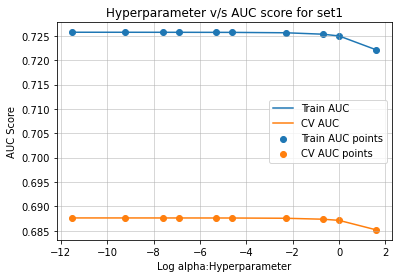

In [21]:
plt.plot(log_alpha,train_auc1,label='Train AUC')
plt.plot(log_alpha,cv_auc1,label='CV AUC')
plt.scatter(log_alpha,train_auc1,label='Train AUC points')
plt.scatter(log_alpha,cv_auc1,label='CV AUC points')

plt.legend()
plt.xlabel('Log alpha:Hyperparameter')
plt.ylabel('AUC Score')
plt.title('Hyperparameter v/s AUC score for set1')
plt.grid(linewidth=0.5)
plt.show()
plt.close()

In [22]:
#best alpha value for set1 
best_alpha1=0.0005

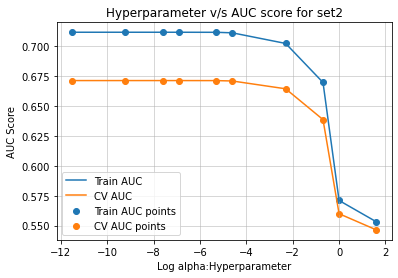

In [23]:
plt.plot(log_alpha,train_auc2,label='Train AUC')
plt.plot(log_alpha,cv_auc2,label='CV AUC')
plt.scatter(log_alpha,train_auc2,label='Train AUC points')
plt.scatter(log_alpha,cv_auc2,label='CV AUC points')

plt.legend()
plt.xlabel('Log alpha:Hyperparameter')
plt.ylabel('AUC Score')
plt.title('Hyperparameter v/s AUC score for set2')
plt.grid(linewidth=0.5)
plt.show()
plt.close()

In [24]:
#best alpha value for set2
best_alpha2=0.001

In [25]:
def batch_predict(clf, data):
    y_data_pred=[]
    loop=data.shape[0]-data.shape[0]%1000
    for i in range(0,loop,1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
        
    #predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[loop:])[:,1])
    
    return y_data_pred

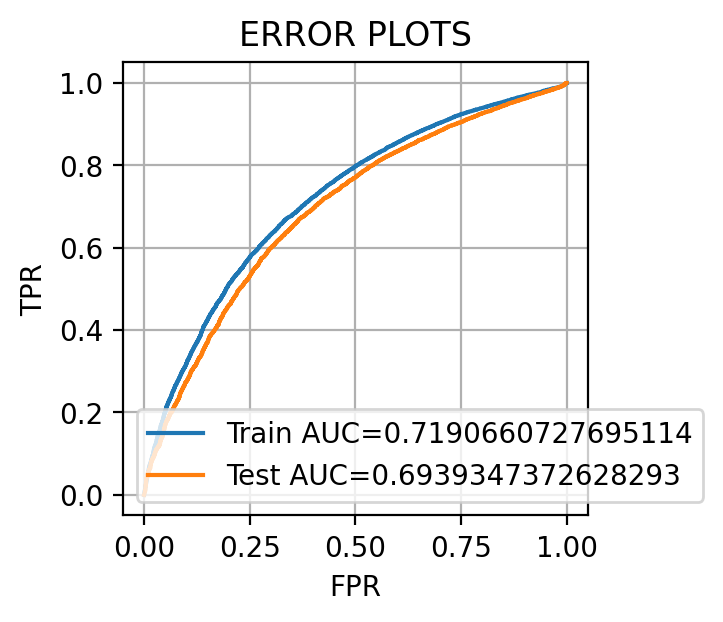

In [27]:
from sklearn.metrics import roc_curve,auc

neigh=MultinomialNB(alpha=best_alpha1)
neigh.fit(X_train_set1,y_train)

y_train_pred1=batch_predict(neigh,X_train_set1)
y_test_pred1=batch_predict(neigh,X_te1)

train_fpr1,train_tpr1,tr_thresholds1=roc_curve(y_train,y_train_pred1)
test_fpr1,test_tpr1,te_thresholds1=roc_curve(y_test,y_test_pred1)

plt.figure(figsize=(3,3), dpi=200)
plt.plot(train_fpr1,train_tpr1,label='Train AUC='+str(auc(train_fpr1,train_tpr1)))
plt.plot(test_fpr1, test_tpr1,label='Test AUC='+str(auc(test_fpr1,test_tpr1)))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ERROR PLOTS')
plt.grid()
plt.show()

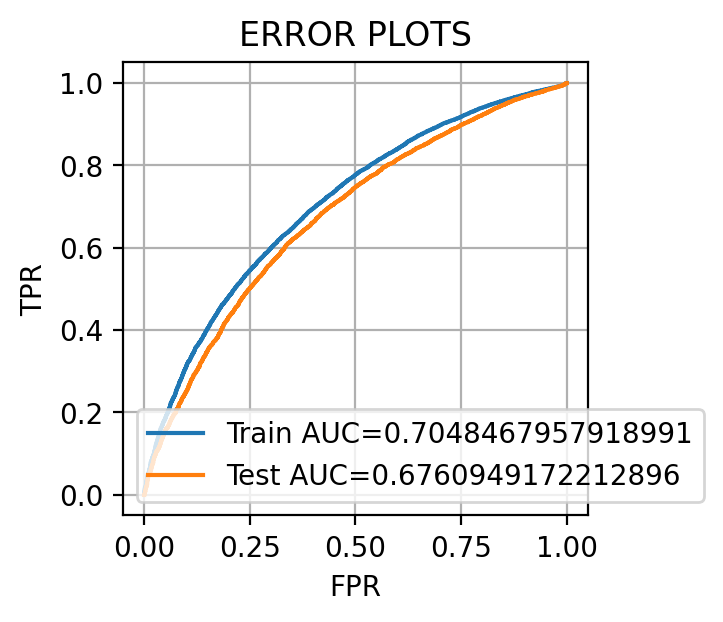

In [28]:
from sklearn.metrics import roc_curve,auc

neigh=MultinomialNB(alpha=best_alpha2)
neigh.fit(X_train_set2,y_train)

y_train_pred2=batch_predict(neigh,X_train_set2)
y_test_pred2=batch_predict(neigh,X_te2)

train_fpr2,train_tpr2,tr_thresholds2=roc_curve(y_train,y_train_pred2)
test_fpr2,test_tpr2,te_thresholds2=roc_curve(y_test,y_test_pred2)

plt.figure(figsize=(3,3), dpi=200)
plt.plot(train_fpr2,train_tpr2,label='Train AUC='+str(auc(train_fpr2,train_tpr2)))
plt.plot(test_fpr2, test_tpr2,label='Test AUC='+str(auc(test_fpr2,test_tpr2)))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ERROR PLOTS')
plt.grid()
plt.show()

In [29]:
def find_best_threshold(threshold,fpr,tpr,set_no):
    t=threshold[np.argmax(tpr*(1-fpr))]
    print("The maximum value of tpr*(1-fpr)",max(tpr*(1-fpr)),"for threshold",np.round(t,3),"for set",set_no)
    return t

def predict_with_best_t(proba,threshold):
    predictions=[]
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [30]:
from sklearn.metrics import confusion_matrix
best_t1=find_best_threshold(tr_thresholds1,train_fpr1,train_tpr1,1)
print("Train confusion matrix")
print(confusion_matrix(y_train,predict_with_best_t(y_train_pred1,best_t1)))
print("Test confusion matrix")
print(confusion_matrix(y_test,predict_with_best_t(y_test_pred1,best_t1)))

The maximum value of tpr*(1-fpr) 0.4451950566356477 for threshold 0.836 for set 1
Train confusion matrix
[[ 5472  2760]
 [14983 30385]]
Test confusion matrix
[[ 2575  1479]
 [ 7474 14872]]


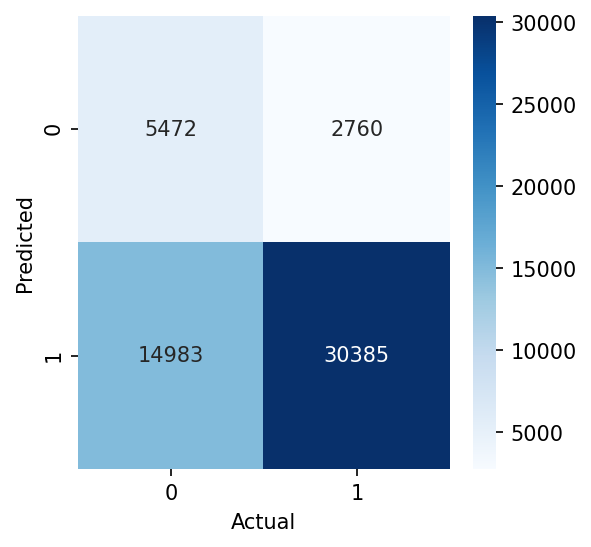

In [45]:
plt.figure(figsize=(4,4), dpi=150)
ax=sns.heatmap(np.array(confusion_matrix(y_train,predict_with_best_t(y_train_pred1,best_t1))), annot=True,fmt="d",cmap='Blues')
ax.set(xlabel='Actual',ylabel='Predicted')
plt.show()

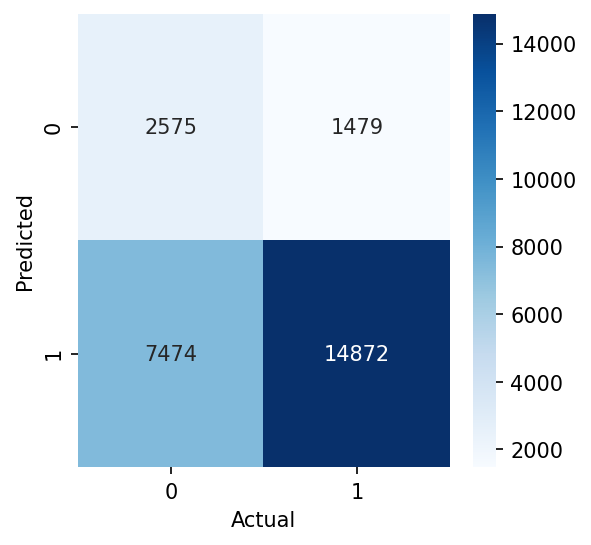

In [47]:
plt.figure(figsize=(4,4), dpi=150)
ax=sns.heatmap(np.array(confusion_matrix(y_test,predict_with_best_t(y_test_pred1,best_t1))), annot=True,fmt="d",cmap='Blues')
ax.set(xlabel='Actual',ylabel='Predicted')
plt.show()

In [33]:
from sklearn.metrics import confusion_matrix
best_t2=find_best_threshold(tr_thresholds2,train_fpr2,train_tpr2,2)
print("Train confusion matrix")
print(confusion_matrix(y_train,predict_with_best_t(y_train_pred2,best_t2)))
print("Test confusion matrix")
print(confusion_matrix(y_test,predict_with_best_t(y_test_pred2,best_t2)))

The maximum value of tpr*(1-fpr) 0.418459177761338 for threshold 0.844 for set 2
Train confusion matrix
[[ 5244  2988]
 [15566 29802]]
Test confusion matrix
[[ 2354  1700]
 [ 7870 14476]]


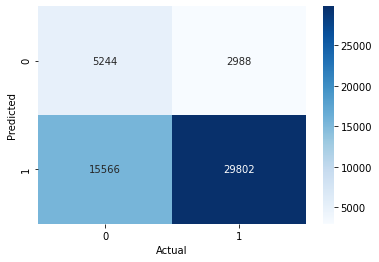

In [34]:
ax=sns.heatmap(np.array(confusion_matrix(y_train,predict_with_best_t(y_train_pred2,best_t2))), annot=True,fmt="d",cmap='Blues')
ax.set(xlabel='Actual',ylabel='Predicted')
plt.show()

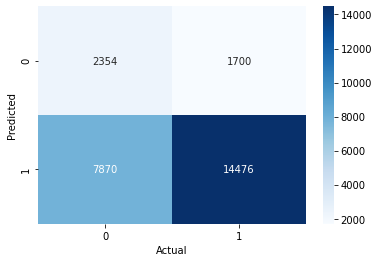

In [35]:
ax=sns.heatmap(np.array(confusion_matrix(y_test,predict_with_best_t(y_test_pred2,best_t2))), annot=True,fmt="d",cmap='Blues')
ax.set(xlabel='Actual',ylabel='Predicted')
plt.show()

In [36]:
print(len(l),len(p))

5297 5297


<h3> Top 20 positive features for set1

In [37]:
feature=neigh.feature_log_prob_[1,:].argsort()[::-1][:5263]
for i in feature[:30]:
    print(l[i])

mrs
grades_prek_2
ms
grades_3_5
literacy_language
math_science
literacy
grades_6_8
ca
mathematics
health_sports
students
literature_writing
literacy_language math_science
grades_9_12
mr
specialneeds
specialneeds
health_wellness
music_arts
tx
ny
appliedlearning
literacy mathematics
fl
appliedsciences
nc
school
literature_writing mathematics
literacy literature_writing


<h3> Top 20 negative features for set1

In [38]:
feature=neigh.feature_log_prob_[0,:].argsort()[::-1][:5263]
for i in feature[:30]:
    print(l[i])

mrs
grades_prek_2
ms
grades_3_5
literacy_language
math_science
grades_6_8
mathematics
literacy
ca
health_sports
students
grades_9_12
literature_writing
mr
tx
literacy_language math_science
specialneeds
specialneeds
appliedlearning
music_arts
appliedsciences
fl
health_wellness
ny
literacy mathematics
school
nc
visualarts
learning


<h3> Top 20 positive features for set2

In [39]:
feature=neigh.feature_log_prob_[1,:].argsort()[::-1][:5263]
for i in feature[:30]:
    print(p[i])

mrs
grades_prek_2
ms
grades_3_5
literacy_language
math_science
literacy
grades_6_8
ca
mathematics
health_sports
students
literature_writing
literacy_language math_science
grades_9_12
mr
specialneeds
specialneeds
health_wellness
music_arts
tx
ny
appliedlearning
literacy mathematics
fl
appliedsciences
nc
school
literature_writing mathematics
literacy literature_writing


<h3> Top 20 negative features for set2

In [40]:
feature=neigh.feature_log_prob_[0,:].argsort()[::-1][:5263]
for i in feature[:30]:
    print(p[i])

mrs
grades_prek_2
ms
grades_3_5
literacy_language
math_science
grades_6_8
mathematics
literacy
ca
health_sports
students
grades_9_12
literature_writing
mr
tx
literacy_language math_science
specialneeds
specialneeds
appliedlearning
music_arts
appliedsciences
fl
health_wellness
ny
literacy mathematics
school
nc
visualarts
learning


<h1>3. Summary with class priors</h1>

<br> as mentioned in the step 5 of instructions

In [41]:
from prettytable import PrettyTable

table=PrettyTable()
table.field_names=['Vectorizer','Model','Hyperparameter(alpha value)','AUC']

table.add_row(['BOW','Multinomial NB','0.0005','0.68'])
table.add_row(['TFIDF','Multinomial NB','0.001','0.66'])

print(table)

+------------+----------------+-----------------------------+------+
| Vectorizer |     Model      | Hyperparameter(alpha value) | AUC  |
+------------+----------------+-----------------------------+------+
|    BOW     | Multinomial NB |            0.0005           | 0.68 |
|   TFIDF    | Multinomial NB |            0.001            | 0.66 |
+------------+----------------+-----------------------------+------+


<h1> Using fit-prior in Multinomial NB

In [42]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB

parameters={'alpha':[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}

neigh=MultinomialNB(fit_prior=True)
#print(neigh.get_params().keys())
clf1=RandomizedSearchCV(neigh,parameters,scoring='roc_auc',cv=5,n_jobs=-1,return_train_score=True)
clf1.fit(X_train_set1,y_train)

clf2=RandomizedSearchCV(neigh,parameters,scoring='roc_auc',cv=5,n_jobs=-1,return_train_score=True)
clf2.fit(X_train_set2,y_train)

results1=pd.DataFrame.from_dict(clf1.cv_results_)
results1=results1.sort_values(['param_alpha'])

results2=pd.DataFrame.from_dict(clf2.cv_results_)
results2=results2.sort_values(['param_alpha'])

train_auc1=results1['mean_train_score']
train_auc_std1=results1['std_train_score']
cv_auc1=results1['mean_test_score']
cv_auc_std1=results1['std_test_score']
alpha1=results1['param_alpha']
train_auc2=results2['mean_train_score']
train_auc_std2=results2['std_train_score']
cv_auc2=results2['mean_test_score']
cv_auc_std2=results2['std_test_score']
alpha2=results2['param_alpha']

In [43]:
results1.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
3,0.147876,0.005277,0.014738,0.001401,0.00001,{'alpha': 1e-05},0.699283,0.696150,0.678238,0.694034,...,0.689790,0.008427,3,0.727541,0.726696,0.730301,0.726127,0.726037,0.727340,0.001574
5,0.137265,0.004164,0.015892,0.002363,0.00050,{'alpha': 0.0005},0.699316,0.696194,0.678196,0.694007,...,0.689790,0.008451,1,0.727453,0.726645,0.730279,0.726094,0.726008,0.727296,0.001578
9,0.114520,0.023601,0.012475,0.003377,0.00100,{'alpha': 0.001},0.699323,0.696203,0.678184,0.694003,...,0.689790,0.008457,2,0.727431,0.726631,0.730273,0.726084,0.726000,0.727284,0.001579
2,0.154272,0.005195,0.014469,0.000501,0.01000,{'alpha': 0.01},0.699363,0.696229,0.678151,0.693976,...,0.689789,0.008479,4,0.727328,0.726568,0.730240,0.726038,0.725961,0.727227,0.001584
8,0.120462,0.014662,0.017628,0.001025,0.05000,{'alpha': 0.05},0.699387,0.696229,0.678126,0.693936,...,0.689775,0.008493,5,0.727208,0.726484,0.730180,0.725967,0.725900,0.727148,0.001587


In [44]:
results2.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
3,0.132715,0.016824,0.023286,0.005873,0.0001,{'alpha': 0.0001},0.667516,0.668711,0.649448,0.671288,...,0.663070,0.008082,1,0.705261,0.705041,0.706382,0.705533,0.705016,0.705447,0.000503
2,0.136135,0.012573,0.015629,0.000630,0.0005,{'alpha': 0.0005},0.667513,0.668708,0.649445,0.671284,...,0.663067,0.008082,2,0.705256,0.705037,0.706377,0.705528,0.705012,0.705442,0.000503
4,0.122254,0.009416,0.020930,0.002618,0.0010,{'alpha': 0.001},0.667509,0.668706,0.649442,0.671281,...,0.663064,0.008082,3,0.705251,0.705031,0.706371,0.705522,0.705007,0.705436,0.000503
8,0.157042,0.022710,0.031092,0.011695,0.0050,{'alpha': 0.005},0.667477,0.668677,0.649413,0.671248,...,0.663033,0.008081,4,0.705207,0.704982,0.706324,0.705476,0.704962,0.705390,0.000503
6,0.132913,0.008595,0.021968,0.003625,0.0500,{'alpha': 0.05},0.667113,0.668335,0.649176,0.670897,...,0.662702,0.008044,5,0.704707,0.704429,0.705805,0.704962,0.704460,0.704873,0.000504


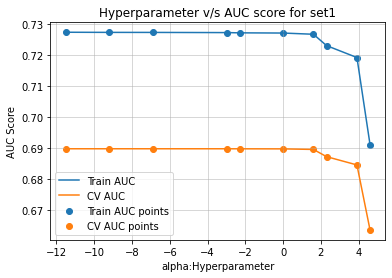

In [45]:
plt.plot(log_alpha,train_auc1,label='Train AUC')
plt.plot(log_alpha,cv_auc1,label='CV AUC')
plt.scatter(log_alpha,train_auc1,label='Train AUC points')
plt.scatter(log_alpha,cv_auc1,label='CV AUC points')

plt.legend()
plt.xlabel('alpha:Hyperparameter')
plt.ylabel('AUC Score')
plt.title('Hyperparameter v/s AUC score for set1')
plt.grid(linewidth=0.5)
plt.show()
plt.close()

In [46]:
#We can see change the change in best hyperparameter value for set1.
best_alpha1=0.5

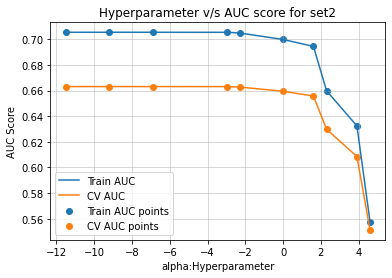

In [47]:
plt.plot(log_alpha,train_auc2,label='Train AUC')
plt.plot(log_alpha,cv_auc2,label='CV AUC')
plt.scatter(log_alpha,train_auc2,label='Train AUC points')
plt.scatter(log_alpha,cv_auc2,label='CV AUC points')

plt.legend()
plt.xlabel('alpha:Hyperparameter')
plt.ylabel('AUC Score')
plt.title('Hyperparameter v/s AUC score for set2')
plt.grid(linewidth=0.5)
plt.show()
plt.close()

In [48]:
#We can see change the change in best hyperparameter value for set2.
best_alpha2=0.05

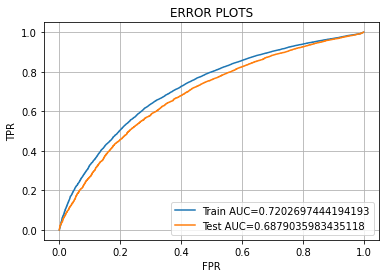

In [49]:
from sklearn.metrics import roc_curve,auc

neigh=MultinomialNB(alpha=best_alpha1)
neigh.fit(X_train_set1,y_train)

y_train_pred1=batch_predict(neigh,X_train_set1)
y_test_pred1=batch_predict(neigh,X_te1)

train_fpr1,train_tpr1,tr_thresholds1=roc_curve(y_train,y_train_pred1)
test_fpr1,test_tpr1,te_thresholds1=roc_curve(y_test,y_test_pred1)

plt.plot(train_fpr1,train_tpr1,label='Train AUC='+str(auc(train_fpr1,train_tpr1)))
plt.plot(test_fpr1, test_tpr1,label='Test AUC='+str(auc(test_fpr1,test_tpr1)))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ERROR PLOTS')
plt.grid()
plt.show()

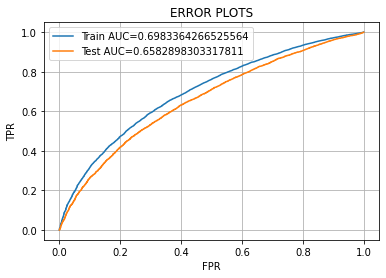

In [50]:
from sklearn.metrics import roc_curve,auc

neigh=MultinomialNB(alpha=best_alpha2)
neigh.fit(X_train_set2,y_train)

y_train_pred2=batch_predict(neigh,X_train_set2)
y_test_pred2=batch_predict(neigh,X_te2)

train_fpr2,train_tpr2,tr_thresholds2=roc_curve(y_train,y_train_pred2)
test_fpr2,test_tpr2,te_thresholds2=roc_curve(y_test,y_test_pred2)

plt.plot(train_fpr2,train_tpr2,label='Train AUC='+str(auc(train_fpr2,train_tpr2)))
plt.plot(test_fpr2, test_tpr2,label='Test AUC='+str(auc(test_fpr2,test_tpr2)))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ERROR PLOTS')
plt.grid()
plt.show()

In [51]:
from sklearn.metrics import confusion_matrix
best_t1=find_best_threshold(tr_thresholds1,train_fpr1,train_tpr1,1)
print("Train confusion matrix")
print(confusion_matrix(y_train,predict_with_best_t(y_train_pred1,best_t1)))
print("Test confusion matrix")
print(confusion_matrix(y_test,predict_with_best_t(y_test_pred1,best_t1)))

The maximum value of tpr*(1-fpr) 0.44678255225938523 for threshold 0.868 for set 1
Train confusion matrix
[[ 5653  2579]
 [15851 29517]]
Test confusion matrix
[[ 2605  1449]
 [ 7966 14380]]


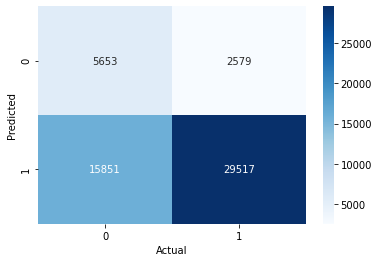

In [52]:
ax=sns.heatmap(np.array(confusion_matrix(y_train,predict_with_best_t(y_train_pred1,best_t1))), annot=True,fmt="d",cmap='Blues')
ax.set(xlabel='Actual',ylabel='Predicted')
plt.show()

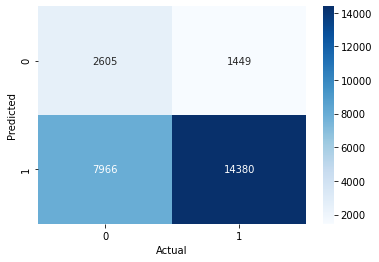

In [53]:
ax=sns.heatmap(np.array(confusion_matrix(y_test,predict_with_best_t(y_test_pred1,best_t1))), annot=True,fmt="d",cmap='Blues')
ax.set(xlabel='Actual',ylabel='Predicted')
plt.show()

In [54]:
from sklearn.metrics import confusion_matrix
best_t2=find_best_threshold(tr_thresholds2,train_fpr2,train_tpr2,2)
print("Train confusion matrix")
print(confusion_matrix(y_train,predict_with_best_t(y_train_pred2,best_t2)))
print("Test confusion matrix")
print(confusion_matrix(y_test,predict_with_best_t(y_test_pred2,best_t2)))

The maximum value of tpr*(1-fpr) 0.41793086135126645 for threshold 0.846 for set 2
Train confusion matrix
[[ 5298  2934]
 [15907 29461]]
Test confusion matrix
[[ 2390  1664]
 [ 8034 14312]]


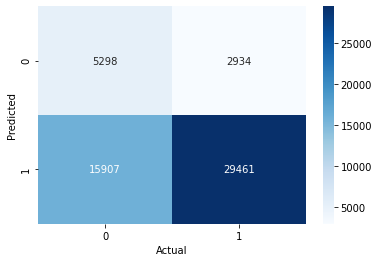

In [55]:
ax=sns.heatmap(np.array(confusion_matrix(y_train,predict_with_best_t(y_train_pred2,best_t2))), annot=True,fmt="d",cmap='Blues')
ax.set(xlabel='Actual',ylabel='Predicted')
plt.show()

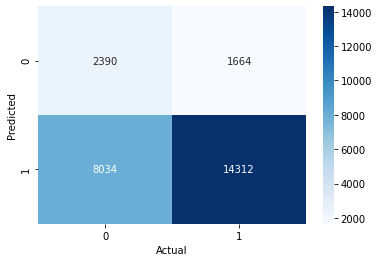

In [56]:
ax=sns.heatmap(np.array(confusion_matrix(y_test,predict_with_best_t(y_test_pred2,best_t2))), annot=True,fmt="d",cmap='Blues')
ax.set(xlabel='Actual',ylabel='Predicted')
plt.show()

<h3> Top 20 positive features for set1

In [57]:
feature=neigh.feature_log_prob_[1,:].argsort()[::-1][:5263]
for i in feature[:30]:
    print(l[i])

mrs
grades_prek_2
ms
grades_3_5
literacy_language
math_science
literacy
grades_6_8
ca
mathematics
health_sports
students
literature_writing
literacy_language math_science
grades_9_12
mr
specialneeds
specialneeds
health_wellness
music_arts
tx
ny
appliedlearning
literacy mathematics
fl
appliedsciences
nc
school
literature_writing mathematics
literacy literature_writing


<h3> Top 20 negative features for set1

In [58]:
feature=neigh.feature_log_prob_[0,:].argsort()[::-1][:5263]
for i in feature[:30]:
    print(l[i])

mrs
grades_prek_2
ms
grades_3_5
literacy_language
math_science
grades_6_8
mathematics
literacy
ca
health_sports
students
grades_9_12
literature_writing
mr
tx
literacy_language math_science
specialneeds
specialneeds
appliedlearning
music_arts
appliedsciences
fl
health_wellness
ny
literacy mathematics
school
nc
visualarts
learning


<h3> Top 20 positive features for set2

In [59]:
feature=neigh.feature_log_prob_[1,:].argsort()[::-1][:5263]
for i in feature[:30]:
    print(p[i])

mrs
grades_prek_2
ms
grades_3_5
literacy_language
math_science
literacy
grades_6_8
ca
mathematics
health_sports
students
literature_writing
literacy_language math_science
grades_9_12
mr
specialneeds
specialneeds
health_wellness
music_arts
tx
ny
appliedlearning
literacy mathematics
fl
appliedsciences
nc
school
literature_writing mathematics
literacy literature_writing


<h3> Top 20 negative features for set2

In [60]:
feature=neigh.feature_log_prob_[0,:].argsort()[::-1][:5263]
for i in feature[:30]:
    print(p[i])

mrs
grades_prek_2
ms
grades_3_5
literacy_language
math_science
grades_6_8
mathematics
literacy
ca
health_sports
students
grades_9_12
literature_writing
mr
tx
literacy_language math_science
specialneeds
specialneeds
appliedlearning
music_arts
appliedsciences
fl
health_wellness
ny
literacy mathematics
school
nc
visualarts
learning


<h1>3. Summary without class priors i.e. with fit-priors</h1>

<br> as mentioned in the step 5 of instructions

In [61]:
from prettytable import PrettyTable

table=PrettyTable()
table.field_names=['Vectorizer','Model','Hyperparameter(alpha value)','AUC']

table.add_row(['BOW','Multinomial NB','0.5','0.68'])
table.add_row(['TFIDF','Multinomial NB','0.05','0.66'])

print(table)

+------------+----------------+-----------------------------+------+
| Vectorizer |     Model      | Hyperparameter(alpha value) | AUC  |
+------------+----------------+-----------------------------+------+
|    BOW     | Multinomial NB |             0.5             | 0.68 |
|   TFIDF    | Multinomial NB |             0.05            | 0.66 |
+------------+----------------+-----------------------------+------+
